In [1]:
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform
import pathlib
import random
from tensorflow import keras
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: Windows-10-10.0.22621-SP0
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
Pandas 1.5.1
Scikit-Learn 1.1.3
SciPy 1.9.3
GPU is available


In [2]:
# Variables and params
BATCH_SIZE = 300
NUM_EPOCH = 200
BUFFER_SIZE = math.ceil((8*1024*1024*1024*7)/(256*256*3*8) )#how many images in 7GB of VRAM

train_root = pathlib.Path('../FruitScale/dataextended/Training')
train_root = train_root.resolve()

test_root = pathlib.Path('../FruitScale/dataextended/Test')
test_root = test_root.resolve()

random.seed(42)

In [3]:
# Useful functions
def create_image_tensor(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    grayscale = tf.image.rgb_to_grayscale(image)
    hsv = tf.image.rgb_to_hsv(image)
    res = tf.concat([hsv, grayscale], 2)
    #res = image
    return res

def augment(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.random_hue(image, 0.02)
    image = tf.image.random_hue(image, 0.02)
    image = tf.image.random_saturation(image, 0.9, 1.2)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return create_image_tensor(image)

def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.image.resize(image, [256, 256])
    return image
    #return augment(image)

In [4]:
# Setting labels and image paths
all_image_paths = list(train_root.glob('*/*'))
all_image_paths_test = list(test_root.glob('*/*'))
random.shuffle(all_image_paths)
random.shuffle(all_image_paths_test)
#print(all_image_paths[10])

total_image_count = len(all_image_paths)
total_image_count_test = len(all_image_paths_test)

validation_count = math.ceil(total_image_count * 0.20)
training_count = total_image_count - validation_count

# Training images
train_labels = [str(path.parent.name) for path in all_image_paths[0: training_count]]
train_image_path = [str(path) for path in all_image_paths[0: training_count]]
train_labels = list(dict.fromkeys(train_labels))
print("Number of train labels: " + str(len(train_labels)))
print("total training count: " + str(len(train_image_path)))
print(train_labels)

# Validation images
validation_labels = [str(path.parent.name) for path in all_image_paths[training_count:]]
validation_image_path = [str(path) for path in all_image_paths[training_count:]]
validation_labels = list(dict.fromkeys(validation_labels))
print("Number of validation labels: " + str(len(validation_labels)))
print("total validation count: " + str(len(validation_image_path)))

# Test images
test_labels = [str(path.parent.name) for path in all_image_paths_test]
test_image_path = [str(path) for path in all_image_paths_test]
test_labels = list(dict.fromkeys(test_labels))
print("Number of test labels: " + str(len(test_labels)))
print("total test count: " + str(len(test_image_path)))

#Generating index
label_to_index = dict((name, index) for index, name in enumerate(train_labels))
#print(label_to_index)

train_labels = [label_to_index[pathlib.Path(path).parent.name]
              for path in train_image_path]

validation_labels = [label_to_index[pathlib.Path(path).parent.name]
                for path in validation_image_path]

test_labels = [label_to_index[pathlib.Path(path).parent.name]
                     for path in test_image_path]

#print(len(train_labels))

Number of train labels: 131
total training count: 304917
['Strawberry Wedge', 'Apple Golden 1', 'Apple Red Yellow 1', 'Pitahaya Red', 'Lychee', 'Apple Red 2', 'Apricot', 'Pepino', 'Kaki', 'Cherry Wax Yellow', 'Apple Red 3', 'Lemon', 'Peach 2', 'Cantaloupe 1', 'Pear 2', 'Cauliflower', 'Banana', 'Apple Golden 3', 'Mulberry', 'Potato Sweet', 'Plum 3', 'Tomato Maroon', 'Pear Forelle', 'Maracuja', 'Cherry Wax Red', 'Lemon Meyer', 'Huckleberry', 'Cherry 2', 'Tomato not Ripened', 'Rambutan', 'Mango Red', 'Plum', 'Guava', 'Fig', 'Quince', 'Tomato Heart', 'Apple Golden 2', 'Pepper Yellow', 'Melon Piel de Sapo', 'Nut Forest', 'Tomato 2', 'Strawberry', 'Granadilla', 'Walnut', 'Nut Pecan', 'Peach Flat', 'Pear', 'Tomato Cherry Red', 'Pear Abate', 'Cherry Wax Black', 'Apple Crimson Snow', 'Grape White', 'Watermelon', 'Beetroot', 'Ginger Root', 'Pepper Green', 'Passion Fruit', 'Corn', 'Grape Blue', 'Hazelnut', 'Nectarine Flat', 'Tomato 4', 'Banana Red', 'Blueberry', 'Cantaloupe 2', 'Peach', 'Papaya',

In [5]:
# Generating the training data set
train_path_ds = tf.data.Dataset.from_tensor_slices(train_image_path)
train_image_ds = train_path_ds.map(load_image, tf.data.AUTOTUNE)
train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.uint8))

train_data = tf.data.Dataset.zip((train_image_ds, train_label_ds))

#ds = data.apply(tf.data.Dataset.shuffle(buffer_size=100000))

train_ds = train_data.shuffle(buffer_size=math.ceil(training_count/4))
train_ds = train_ds.batch(BATCH_SIZE)

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
# Generating the validation dataset
validation_path_ds = tf.data.Dataset.from_tensor_slices(validation_image_path)
validation_image_ds = validation_path_ds.map(load_image, tf.data.AUTOTUNE)
validation_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(validation_labels, tf.uint8))

validation_data = tf.data.Dataset.zip((validation_image_ds, validation_label_ds))

#ds = data.apply(tf.data.Dataset.shuffle(buffer_size=100000))

validation_ds = validation_data.shuffle(buffer_size=math.ceil(validation_count/4))
validation_ds = validation_ds.batch(BATCH_SIZE)

validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
# Generating the test dataset
test_path_ds = tf.data.Dataset.from_tensor_slices(test_image_path)
test_image_ds = test_path_ds.map(load_image, tf.data.AUTOTUNE)
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.uint8))

print(len(test_image_ds))
print(len(test_label_ds))

test_data = tf.data.Dataset.zip((test_image_ds, test_label_ds))

#ds = data.apply(tf.data.Dataset.shuffle(buffer_size=100000))

test_ds = test_data.shuffle(buffer_size=math.ceil(total_image_count_test))
test_ds = test_ds.batch(BATCH_SIZE)

test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

22688
22688


In [8]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(filters=16, kernel_size=(5, 5), input_shape=(256,256,3), activation='relu'))
model.add(keras.layers.MaxPool2D(strides=2))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(keras.layers.MaxPool2D(strides=2))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(keras.layers.MaxPool2D(strides=2))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(keras.layers.MaxPool2D(strides=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(131, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 57, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [9]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=25,
    restore_best_weights=True,)

In [10]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=NUM_EPOCH,
    validation_data=validation_ds,
    verbose=1,
    callbacks=[early_stop],
)

Epoch 1/200
1017/1017 [==============================] - 449s 408ms/step - loss: 1.3174 - accuracy: 0.6975 - val_loss: 0.5693 - val_accuracy: 0.8168
Epoch 2/200
1017/1017 [==============================] - 389s 356ms/step - loss: 0.2434 - accuracy: 0.9215 - val_loss: 0.1817 - val_accuracy: 0.9407
Epoch 3/200
1017/1017 [==============================] - 384s 350ms/step - loss: 0.1404 - accuracy: 0.9542 - val_loss: 0.3429 - val_accuracy: 0.9041
Epoch 4/200
1017/1017 [==============================] - 385s 352ms/step - loss: 0.1256 - accuracy: 0.9603 - val_loss: 0.1481 - val_accuracy: 0.9549
Epoch 5/200
1017/1017 [==============================] - 391s 357ms/step - loss: 0.1128 - accuracy: 0.9650 - val_loss: 0.0946 - val_accuracy: 0.9727
Epoch 6/200
1017/1017 [==============================] - 402s 366ms/step - loss: 0.1038 - accuracy: 0.9685 - val_loss: 0.1155 - val_accuracy: 0.9660
Epoch 7/200
1017/1017 [==============================] - 413s 377ms/step - loss: 0.0902 - accuracy: 0.9729

In [11]:
model.save("trained_CNN.h5")

In [12]:
loss, acc, *is_anything_else_being_returned = model.evaluate(test_ds)
print('Loss:', loss)
print('Accuracy:', acc)

76/76 [==============================] - 47s 194ms/step - loss: 0.3496 - accuracy: 0.9622
Loss: 0.3495502471923828
Accuracy: 0.9621826410293579


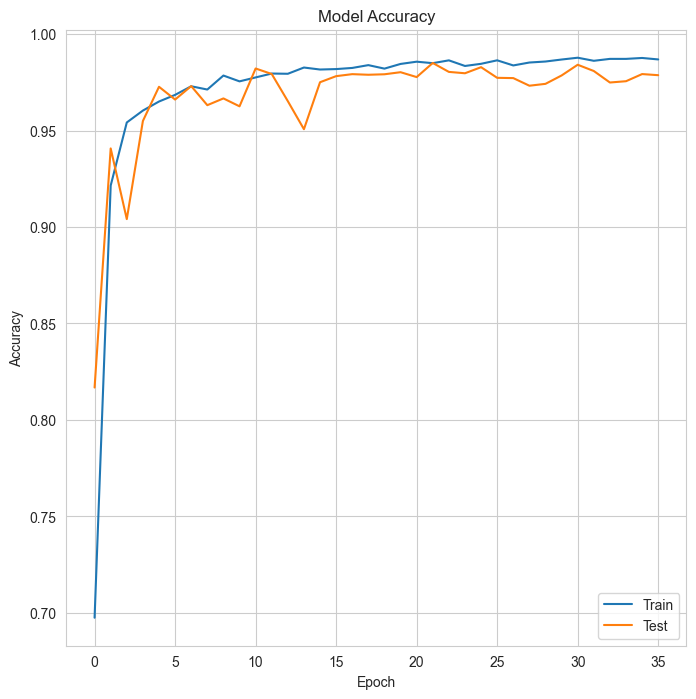

In [13]:

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

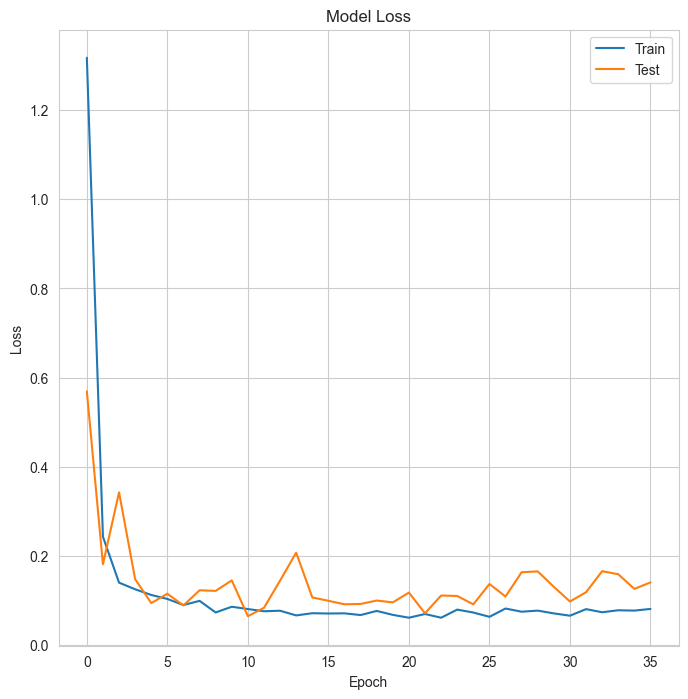

In [14]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [15]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

print(confusion_matrix(y_true=correct_labels, y_pred=predicted_labels))

6/6 [==============================] - 0s 43ms/step
[[224   0   0 ...  15   0   0]
 [  0 155   0 ...   0   0   0]
 [  0   0 164 ...   0   0   0]
 ...
 [  0   0   0 ... 162   0   0]
 [  0   0   0 ...   0 141   0]
 [  0   0   0 ...   0   0 166]]


In [16]:
print(classification_report(correct_labels,predicted_labels))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       246
           1       0.77      0.97      0.86       160
           2       1.00      1.00      1.00       164
           3       0.96      1.00      0.98       166
           4       1.00      1.00      1.00       166
           5       1.00      0.56      0.72       164
           6       1.00      1.00      1.00       164
           7       0.99      0.80      0.88       166
           8       0.85      1.00      0.92       166
           9       1.00      1.00      1.00       164
          10       0.80      1.00      0.89       144
          11       0.99      1.00      1.00       164
          12       1.00      1.00      1.00       246
          13       1.00      1.00      1.00       164
          14       0.99      0.71      0.83       232
          15       0.98      1.00      0.99       234
          16       0.94      1.00      0.97       166
          17       0.91    

<AxesSubplot: >

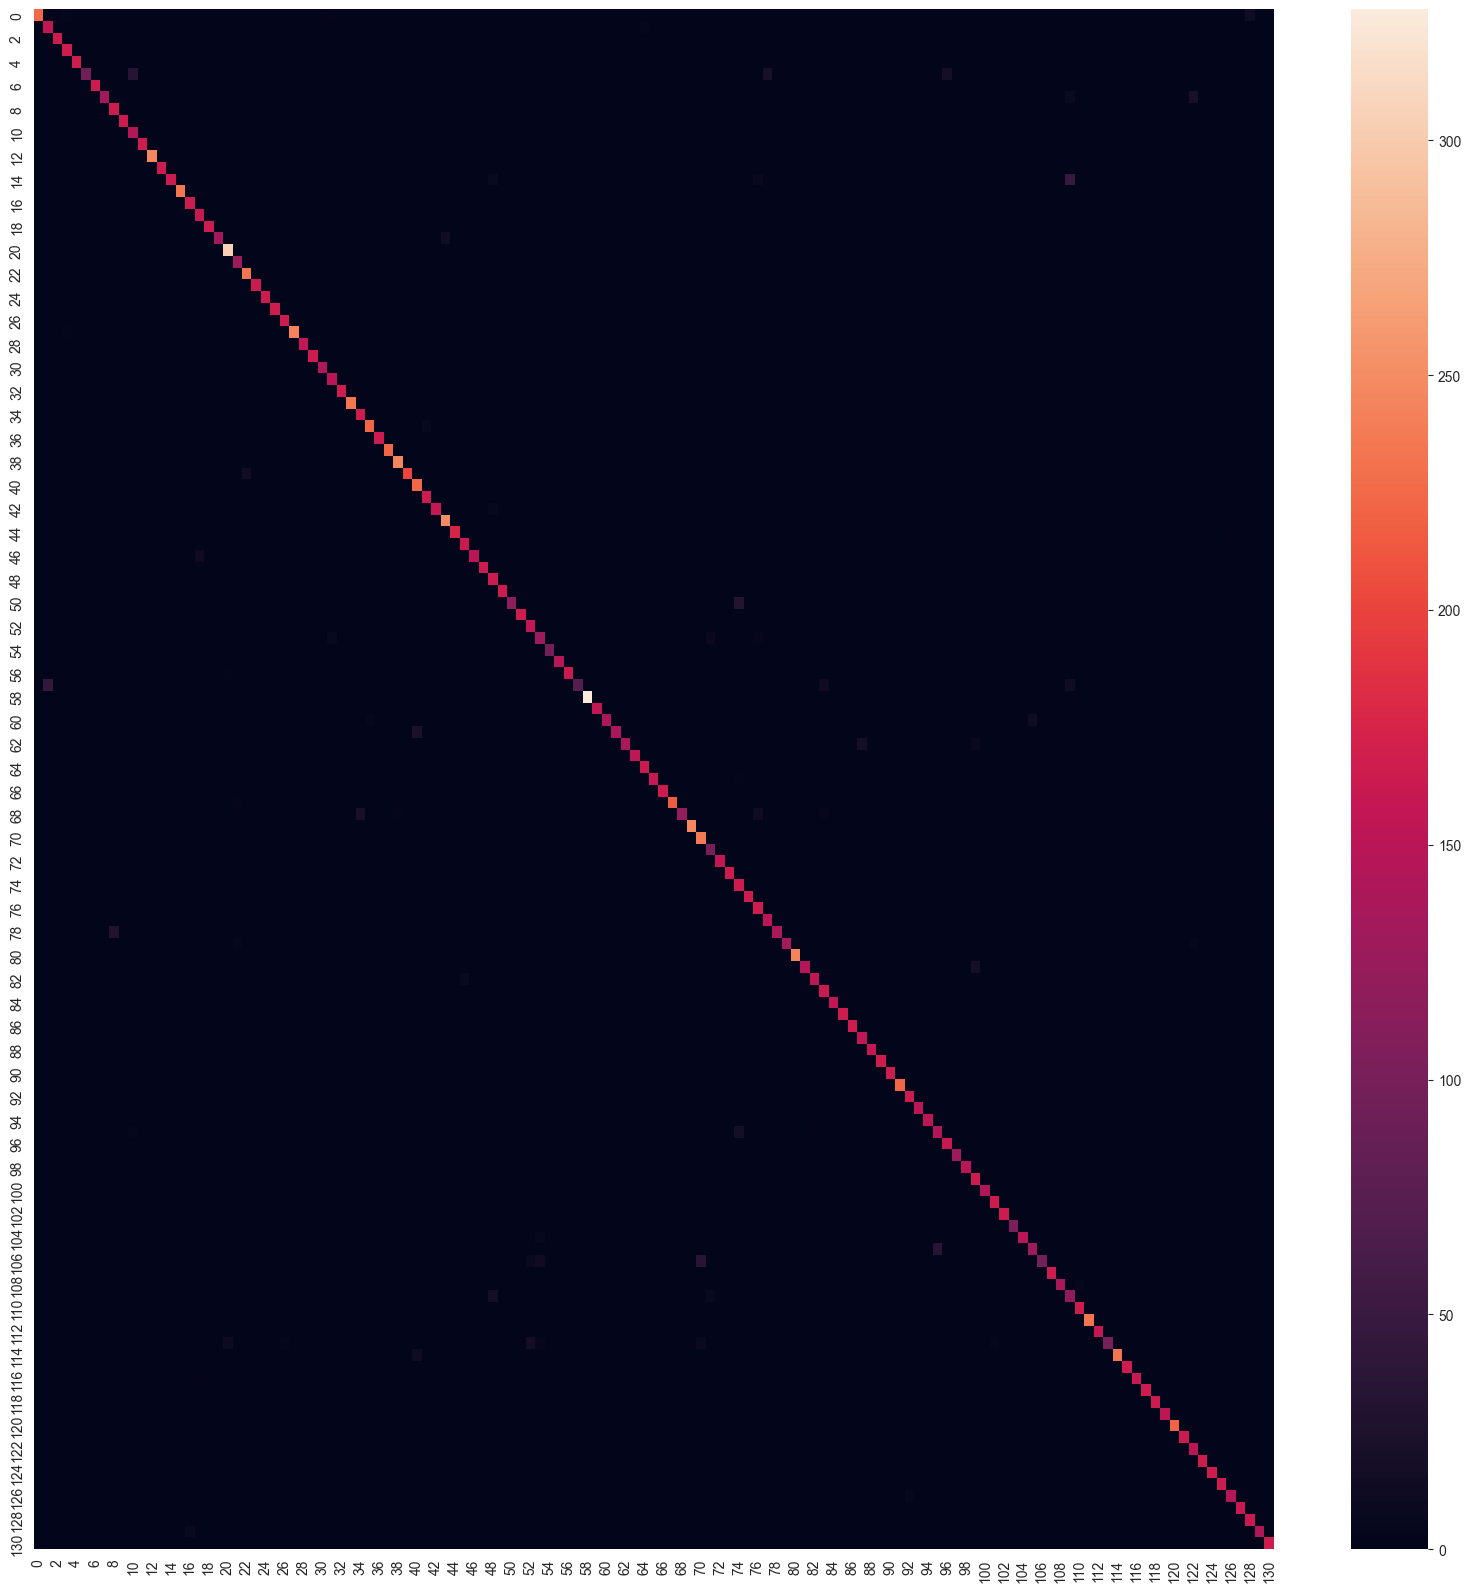

In [17]:
cf_matrix = confusion_matrix(y_true=correct_labels, y_pred=predicted_labels)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cf_matrix, ax=ax,)

In [18]:
index = label_to_index#list(label_to_index.keys())
def getPredictionClass(predictions):
    i=0
    for prediction in predictions:
        if prediction > 0.0:
            k = 0
            for a,b in index.items():
                if k == i:
                    print(a + ": " + str(prediction))
                k = k + 1
        i = i+1

32.jpg
1/1 [==============================] - 0s 83ms/step
Apple Red 3: 1.0


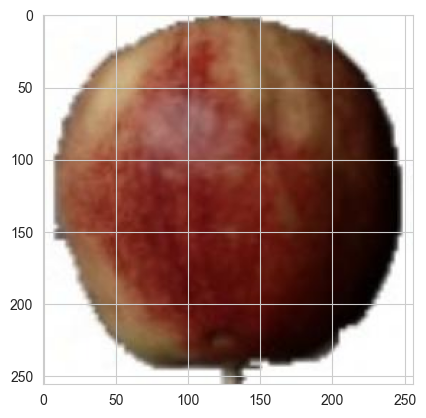

In [19]:
import cv2

x = random.choice(os.listdir(str(test_root) + '/Apple Red 3'))
print(x)
img = plt.imread(os.path.join(str(test_root) + '/Apple Red 3', x))
img = cv2.resize(img, dsize=(256, 256))
#img_new = keras.applications.mobilenet.preprocess_input(img)
plt.imshow(img)
#print(img.shape)
#print((np.expand_dims(img,0).shape))

predictions = model.predict(np.expand_dims(img,0)).round(2)[0]
#print(predictions)
getPredictionClass(predictions)